## Load data

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.lines as mlines
from scipy.stats import mannwhitneyu, wilcoxon

# plt.rcParams.update({'font.size': 12})

In [2]:
datapath = f'/g/data/ng72/as9583/cylc-run/u-dr216/netcdf_new'
variable = 'surface_temperature'

experiment1 = 'drysoil_d0198_RAL3P2_albedo_bare_' 
allvar = xr.open_dataset(f'{datapath}/{variable}/{experiment1}{variable}.nc')[variable]

experiment2 = 'control_d0198_RAL3P2_' 
control = xr.open_dataset(f'{datapath}/{variable}/{experiment2}{variable}.nc')[variable]

experiment3 = 'control_d0198_RAL3P2_albedo_bare_'
albedo_bare = xr.open_dataset(f'{datapath}/{variable}/{experiment3}{variable}.nc')[variable]

experiment4 = 'control_d0198_RAL3P2_albedo_'
albedo = xr.open_dataset(f'{datapath}/{variable}/{experiment4}{variable}.nc')[variable]

experiment5 = 'control_d0198_RAL3P2_bare_'
bare = xr.open_dataset(f'{datapath}/{variable}/{experiment5}{variable}.nc')[variable]

experiment6 = 'drysoil_d0198_RAL3P2_albedo_'
SM_albedo = xr.open_dataset(f'{datapath}/{variable}/{experiment6}{variable}.nc')[variable]

experiment7 = 'drysoil_d0198_RAL3P2_bare_'
SM_bare = xr.open_dataset(f'{datapath}/{variable}/{experiment7}{variable}.nc')[variable]

experiment8 = 'drysoil_d0198_RAL3P2_'
SM = xr.open_dataset(f'{datapath}/{variable}/{experiment8}{variable}.nc')[variable]

In [3]:
#clip to land only
variable3 = 'land_sea_mask'
landmask = xr.open_dataset(f'{datapath}/{variable3}/{experiment1}{variable3}.nc')["land_binary_mask"].isel(time=0)
allvar = allvar.where(landmask == 1)
control = control.where(landmask == 1)
albedo_bare = albedo_bare.where(landmask == 1)
albedo = albedo.where(landmask == 1)
bare = bare.where(landmask == 1)
SM_albedo = SM_albedo.where(landmask == 1)
SM_bare = SM_bare.where(landmask == 1)
SM = SM.where(landmask == 1)

In [4]:
experiments = {
    "AllVar": allvar,
    "Control": control,
    "Albedo_Bare": albedo_bare,
    "Albedo": albedo,
    "Bare": bare,
    "SM_Albedo": SM_albedo,
    "SM_Bare": SM_bare,
    "SM": SM
}


## Fire scars- daily averages and hourly running 

In [5]:
fires = gpd.read_file('/g/data/ng72/as9583/merged_fires.gpkg')
variable2 = 'surface_altitude'
sa1 = xr.open_dataset(f'{datapath}/{variable2}/{experiment1}{variable2}.nc')[variable2].isel(time=0)

In [6]:
#clip to fires
fires = fires.to_crs("EPSG:7844")

clipped = {}

for name, da in experiments.items():
    da = da.rio.write_crs("EPSG:7844")
    
    clipped_da = da.rio.clip(fires.geometry, fires.crs, drop=True, invert=False)
    
    clipped[name] = clipped_da


In [7]:
allvar = clipped['AllVar']
control =clipped['Control']
albedo_bare =clipped['Albedo_Bare']
albedo =clipped['Albedo']
bare =clipped['Bare']
SM_albedo =clipped['SM_Albedo']
SM_bare=clipped['SM_Bare']
SM =clipped['SM']

In [8]:
#fire dictionary
experiments1 = {
    "All Variables": allvar,
    "Control": control,
    "Albedo + Bare": albedo_bare,
    "Albedo": albedo,
    "Bare": bare,
    "SM + Albedo": SM_albedo,
    "SM + Bare": SM_bare,
    "SM": SM
}

## fire scars

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Enteri

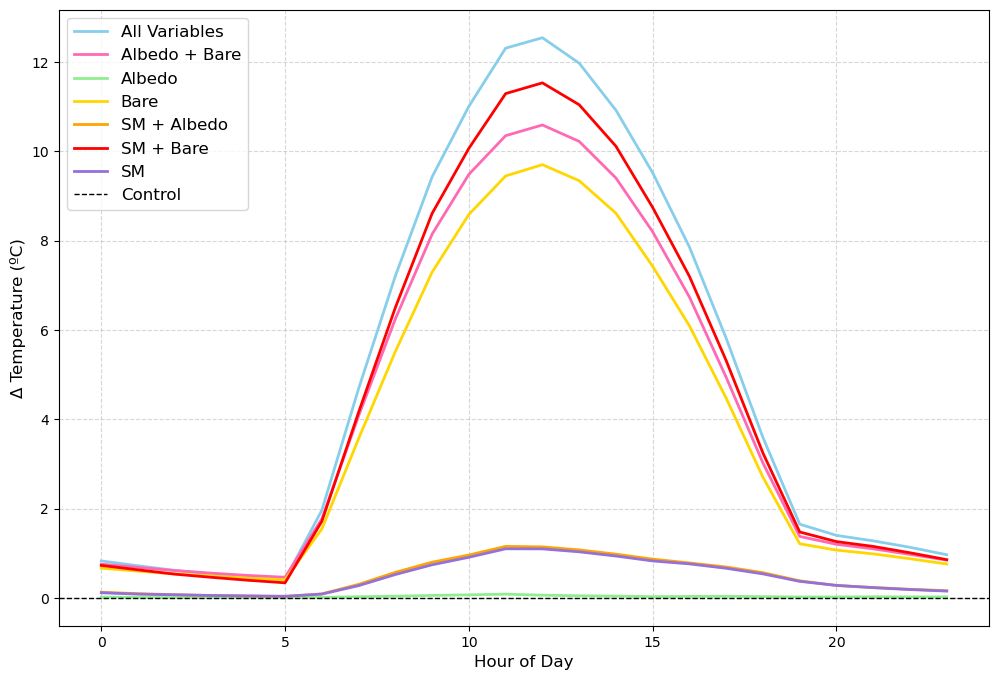

In [9]:
colors = ["skyblue", "hotpink", "lightgreen", "gold", 
          "orange", "red", "mediumpurple", "pink"]
#spatial mean
t_series = {}
for name, da in experiments1.items():
    da = da.assign_coords(time=da.time + pd.Timedelta(hours=10)) #shift to AEST
    t_series[name] = da.mean(dim=["latitude", "longitude"], skipna=True)

#diurnal cycle
t_diurnal = {}
for name, series in t_series.items():
    t_diurnal[name] = series.groupby("time.hour").mean("time")

ref = t_diurnal["Control"]

#diff from control
t_diff = {}
for name, series in t_diurnal.items():
    if name != "Control":
        #align on hour
        series, ref_aligned = xr.align(series, ref)
        t_diff[name] = series - ref_aligned

plt.figure(figsize=(12,8))


for (name, diff), color in zip(t_diff.items(), colors):
    plt.plot(diff["hour"], diff.values, label=name, color=color, linewidth=2)
# for name, diff in t_diff.items():
#     plt.plot(diff["hour"], diff.values, label=f"{name}")

plt.axhline(0, color="k", linestyle="--", linewidth=1, label = 'Control')
# plt.title("Surface Temperature Difference from Control (fire scars)")
plt.xlabel("Hour of Day", fontsize = 12)
plt.ylabel("Δ Temperature (ºC)", fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, linestyle="--", alpha=0.5)
plt.savefig("/g/data/ng72/as9583/new_analysis/figures/temp_surface_diurnal.png", dpi=300, bbox_inches="tight")
plt.show()

